# Telecom Churn Prediction 
**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [430]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [431]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [432]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)
# Change source for below files before submitting

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

#data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
#unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
#sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [433]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


<h1><b>Data understanding, preparation & pre-processing </b></h1>

In [434]:
# Rows of initial data
data.head(10)

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.00,0.00,0.00,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.00,0.00,0.00,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,0
5,5,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,86.193,83.351,...,0,0,NaN,NaN,NaN,698,0.00,0.00,0.00,0
6,6,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,54.173,95.130,...,0,0,NaN,NaN,NaN,1083,0.00,0.00,0.00,0
7,7,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,167.861,167.869,...,0,0,1.0,1.0,1.0,584,82.26,73.56,177.14,0
8,8,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,163.550,90.250,...,0,0,NaN,NaN,NaN,2455,0.00,0.00,0.00,1
9,9,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,101.984,259.265,...,0,0,NaN,NaN,NaN,2530,0.00,0.00,0.00,0


In [435]:
# feature type summary
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

There are 172 columns. Lot of the columns are numeric type, but we need to inspect which are the categorical columns.

In [436]:
data.describe(include='all')

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999,69600,69266,69999.000000,69999.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
unique,NaN,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,69999,69600,69266,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,283.134365,278.185912,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,NaN,NaN,NaN,334.213918,344.366927,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,-2258.709000,-1289.715000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,93.581000,86.714000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,197.484000,191.588000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,NaN,NaN,NaN,370.791000,365.369500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000


In [437]:
# create backup of data
original = data.copy()

Let us check Missing values

In [438]:
# Missing value ratio
pd.options.display.max_rows = 200

data.isnull().sum()*100/data.shape[0]

id                           0.000000
circle_id                    0.000000
loc_og_t2o_mou               1.002871
std_og_t2o_mou               1.002871
loc_ic_t2o_mou               1.002871
last_date_of_month_6         0.000000
last_date_of_month_7         0.570008
last_date_of_month_8         1.047158
arpu_6                       0.000000
arpu_7                       0.000000
arpu_8                       0.000000
onnet_mou_6                  3.954342
onnet_mou_7                  3.838626
onnet_mou_8                  5.290076
offnet_mou_6                 3.954342
offnet_mou_7                 3.838626
offnet_mou_8                 5.290076
roam_ic_mou_6                3.954342
roam_ic_mou_7                3.838626
roam_ic_mou_8                5.290076
roam_og_mou_6                3.954342
roam_og_mou_7                3.838626
roam_og_mou_8                5.290076
loc_og_t2t_mou_6             3.954342
loc_og_t2t_mou_7             3.838626
loc_og_t2t_mou_8             5.290076
loc_og_t2m_m

Drop columns with more than 70% null values

In [439]:
init_cols = data.shape[1]

MISSING_THRESHOLD = 0.7

include_cols = list(data.apply(lambda column: True if column.isnull().sum()/data.shape[0] < MISSING_THRESHOLD else False))

# drop columns
data = data.loc[:, include_cols]

dropped_cols = data.shape[1] - init_cols
print("{0} columns dropped.".format(dropped_cols))

-30 columns dropped.


Check shape of dataset again

In [440]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,0,0,0,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,1,0,0,0,0,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,0,0,0,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,0,0,0,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,0,0,0,1,0,647,0.0,0.0,0.0,0


In [441]:
# drop id and circle_id
print("Shape before dropping: ", data.shape)
data = data.drop(['id','circle_id'], axis=1)
print("Shape after dropping: ", churn.shape)

Shape before dropping:  (69999, 142)
Shape after dropping:  (69999, 140)


In [442]:
# Check missing value ratio now. Most are less than 6% now
data.isnull().sum()*100/data.shape[0]

loc_og_t2o_mou          1.002871
std_og_t2o_mou          1.002871
loc_ic_t2o_mou          1.002871
last_date_of_month_6    0.000000
last_date_of_month_7    0.570008
last_date_of_month_8    1.047158
arpu_6                  0.000000
arpu_7                  0.000000
arpu_8                  0.000000
onnet_mou_6             3.954342
onnet_mou_7             3.838626
onnet_mou_8             5.290076
offnet_mou_6            3.954342
offnet_mou_7            3.838626
offnet_mou_8            5.290076
roam_ic_mou_6           3.954342
roam_ic_mou_7           3.838626
roam_ic_mou_8           5.290076
roam_og_mou_6           3.954342
roam_og_mou_7           3.838626
roam_og_mou_8           5.290076
loc_og_t2t_mou_6        3.954342
loc_og_t2t_mou_7        3.838626
loc_og_t2t_mou_8        5.290076
loc_og_t2m_mou_6        3.954342
loc_og_t2m_mou_7        3.838626
loc_og_t2m_mou_8        5.290076
loc_og_t2f_mou_6        3.954342
loc_og_t2f_mou_7        3.838626
loc_og_t2f_mou_8        5.290076
loc_og_t2c

Impute missing values

In [443]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 140 columns):
 #    Column                Dtype  
---   ------                -----  
 0    loc_og_t2o_mou        float64
 1    std_og_t2o_mou        float64
 2    loc_ic_t2o_mou        float64
 3    last_date_of_month_6  object 
 4    last_date_of_month_7  object 
 5    last_date_of_month_8  object 
 6    arpu_6                float64
 7    arpu_7                float64
 8    arpu_8                float64
 9    onnet_mou_6           float64
 10   onnet_mou_7           float64
 11   onnet_mou_8           float64
 12   offnet_mou_6          float64
 13   offnet_mou_7          float64
 14   offnet_mou_8          float64
 15   roam_ic_mou_6         float64
 16   roam_ic_mou_7         float64
 17   roam_ic_mou_8         float64
 18   roam_og_mou_6         float64
 19   roam_og_mou_7         float64
 20   roam_og_mou_8         float64
 21   loc_og_t2t_mou_6      float64
 22   loc_og_t2t_mou_7    

In [444]:
# create column name list by types of columns


date_type_cols = ['last_date_of_month_6',
             'last_date_of_month_7',
             'last_date_of_month_8',
             'date_of_last_rech_6',
             'date_of_last_rech_7',
             'date_of_last_rech_8',
            ]

num_type_cols = [column for column in data.columns if column not in date_type_cols]


We will impute numerical columns with zeroes as these are less than 6% of overall data

In [445]:

num_type_cols

data[num_type_cols].describe(include='all')

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,132.978257,198.874771,...,0.077730,0.081958,0.075344,0.081444,0.085487,1220.639709,68.108597,65.935830,60.07674,0.101887
std,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,311.896596,316.818355,...,0.383189,0.381821,0.573003,0.634547,0.680035,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,6.410000,34.860000,...,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,32.100000,96.480000,...,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,115.060000,232.990000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,10752.560000,8362.360000,...,16.000000,16.000000,29.000000,33.000000,41.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [446]:
data[num_type_cols] = data[num_type_cols].apply(lambda x: x.fillna(0))

check latest missing value percentage

In [447]:
data.isnull().sum()*100/data.shape[0]

loc_og_t2o_mou          0.000000
std_og_t2o_mou          0.000000
loc_ic_t2o_mou          0.000000
last_date_of_month_6    0.000000
last_date_of_month_7    0.570008
last_date_of_month_8    1.047158
arpu_6                  0.000000
arpu_7                  0.000000
arpu_8                  0.000000
onnet_mou_6             0.000000
onnet_mou_7             0.000000
onnet_mou_8             0.000000
offnet_mou_6            0.000000
offnet_mou_7            0.000000
offnet_mou_8            0.000000
roam_ic_mou_6           0.000000
roam_ic_mou_7           0.000000
roam_ic_mou_8           0.000000
roam_og_mou_6           0.000000
roam_og_mou_7           0.000000
roam_og_mou_8           0.000000
loc_og_t2t_mou_6        0.000000
loc_og_t2t_mou_7        0.000000
loc_og_t2t_mou_8        0.000000
loc_og_t2m_mou_6        0.000000
loc_og_t2m_mou_7        0.000000
loc_og_t2m_mou_8        0.000000
loc_og_t2f_mou_6        0.000000
loc_og_t2f_mou_7        0.000000
loc_og_t2f_mou_8        0.000000
loc_og_t2c

Drop Date Type columns as recharge amount will be 0 for the missing dates

In [448]:

print("Shape before dropping: ", data.shape)
data = data.drop(date_type_cols, axis=1)
print("Shape after dropping: ", data.shape)

Shape before dropping:  (69999, 140)
Shape after dropping:  (69999, 134)


<h1><b>Derive new columns</b></b></h1>

Difference between 8th and previous months.
If customer is churning in 8th month, columns representing change in usage/recharge rate will be important to predict churn

In [449]:
data['std_ic_mou_chg'] = data.std_ic_mou_8 - ((data.std_ic_mou_6 + data.std_ic_mou_7)/2)

data['isd_ic_mou_chg'] = data.isd_ic_mou_8 - ((data.isd_ic_mou_6 + data.isd_ic_mou_7)/2)

data['spl_ic_mou_chg'] = data.spl_ic_mou_8 - ((data.spl_ic_mou_6 + data.spl_ic_mou_7)/2)

data['total_ic_mou_chg'] = data.total_ic_mou_8 - ((data.total_ic_mou_6 + data.total_ic_mou_7)/2)

data['total_rech_num_chg'] = data.total_rech_num_8 - ((data.total_rech_num_6 + data.total_rech_num_7)/2)

data['total_rech_amt_chg'] = data.total_rech_amt_8 - ((data.total_rech_amt_6 + data.total_rech_amt_7)/2)

data['max_rech_amt_chg'] = data.max_rech_amt_8 - ((data.max_rech_amt_6 + data.max_rech_amt_7)/2)

data['vol_2g_mb_chg'] = data.vol_2g_mb_8 - ((data.vol_2g_mb_6 + data.vol_2g_mb_7)/2)

data['vol_3g_mb_chg'] = data.vol_3g_mb_8 - ((data.vol_3g_mb_6 + data.vol_3g_mb_7)/2)

data['arpu_chg'] = data.arpu_8 - ((data.arpu_6 + data.arpu_7)/2)

data['onnet_mou_chg'] = data.onnet_mou_8 - ((data.onnet_mou_6 + data.onnet_mou_7)/2)

data['offnet_mou_chg'] = data.offnet_mou_8 - ((data.offnet_mou_6 + data.offnet_mou_7)/2)

data['roam_ic_mou_chg'] = data.roam_ic_mou_8 - ((data.roam_ic_mou_6 + data.roam_ic_mou_7)/2)

data['roam_og_mou_chg'] = data.roam_og_mou_8 - ((data.roam_og_mou_6 + data.roam_og_mou_7)/2)

data['loc_og_mou_chg'] = data.loc_og_mou_8 - ((data.loc_og_mou_6 + data.loc_og_mou_7)/2)

data['std_og_mou_chg'] = data.std_og_mou_8 - ((data.std_og_mou_6 + data.std_og_mou_7)/2)

data['isd_og_mou_chg'] = data.isd_og_mou_8 - ((data.isd_og_mou_6 + data.isd_og_mou_7)/2)

data['spl_og_mou_chg'] = data.spl_og_mou_8 - ((data.spl_og_mou_6 + data.spl_og_mou_7)/2)

data['total_og_mou_chg'] = data.total_og_mou_8 - ((data.total_og_mou_6 + data.total_og_mou_7)/2)

data['loc_ic_mou_chg'] = data.loc_ic_mou_8 - ((data.loc_ic_mou_6 + data.loc_ic_mou_7)/2)



<h1><b>Exploratory Data Analysis</b></h1>

<h1><b>Data visualization</b></h1>

In [450]:
def univariate_plot(variable, show_stats=True):
        sns.distplot(variable)
        if show_stats == True:
            print(variable.describe())

    

<h1><b>Univariate Explorative Data Analysis</h1>

count    69999.000000
mean       283.134365
std        334.213918
min      -2258.709000
25%         93.581000
50%        197.484000
75%        370.791000
max      27731.088000
Name: arpu_6, dtype: float64


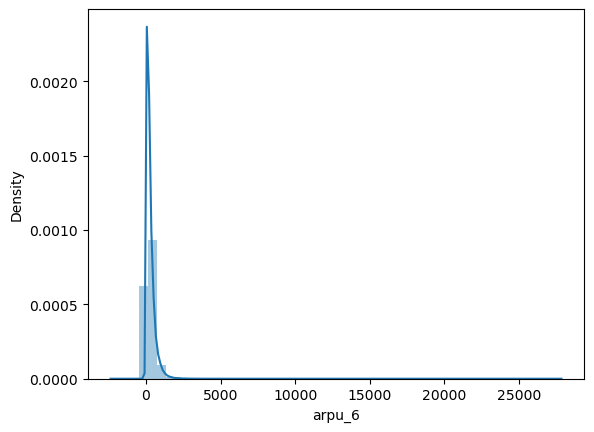

In [451]:
univariate_plot(data.arpu_6)

count    69999.000000
mean       278.185912
std        344.366927
min      -1289.715000
25%         86.714000
50%        191.588000
75%        365.369500
max      35145.834000
Name: arpu_7, dtype: float64


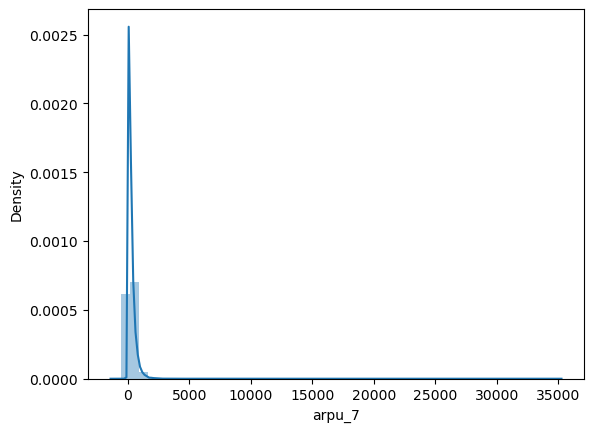

In [452]:
univariate_plot(data.arpu_7)

count    69999.000000
mean       278.858826
std        351.924315
min       -945.808000
25%         84.095000
50%        192.234000
75%        369.909000
max      33543.624000
Name: arpu_8, dtype: float64


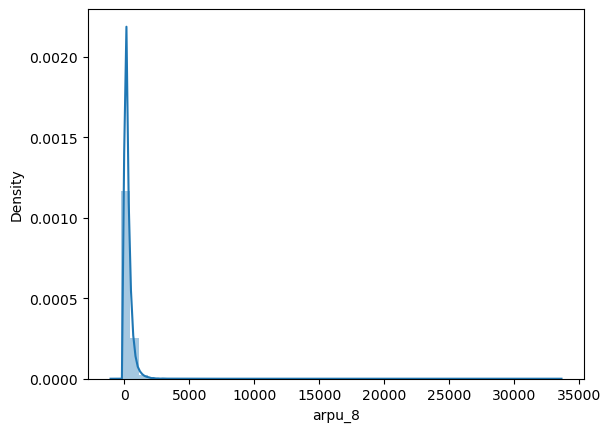

In [453]:
univariate_plot(data.arpu_8)

count    69999.000000
mean       127.887939
std        295.115497
min          0.000000
25%          5.430000
50%         30.830000
75%        113.100000
max       7376.710000
Name: onnet_mou_6, dtype: float64


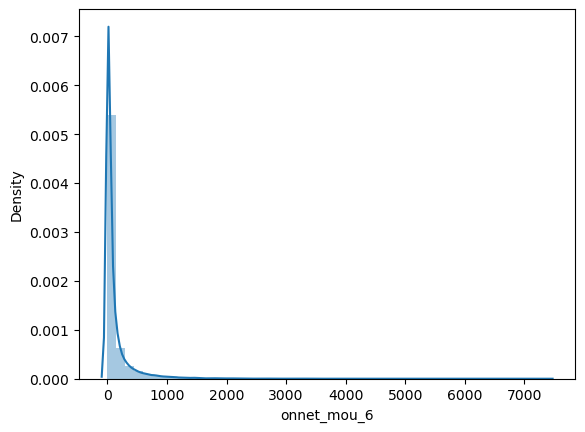

In [454]:
univariate_plot(data.onnet_mou_6)

count    69999.000000
mean         0.075344
std          0.573003
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         29.000000
Name: sachet_3g_6, dtype: float64


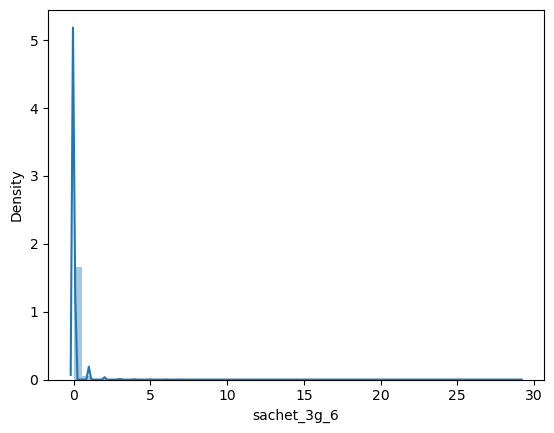

In [455]:
univariate_plot(data.sachet_3g_6)

<Axes: >

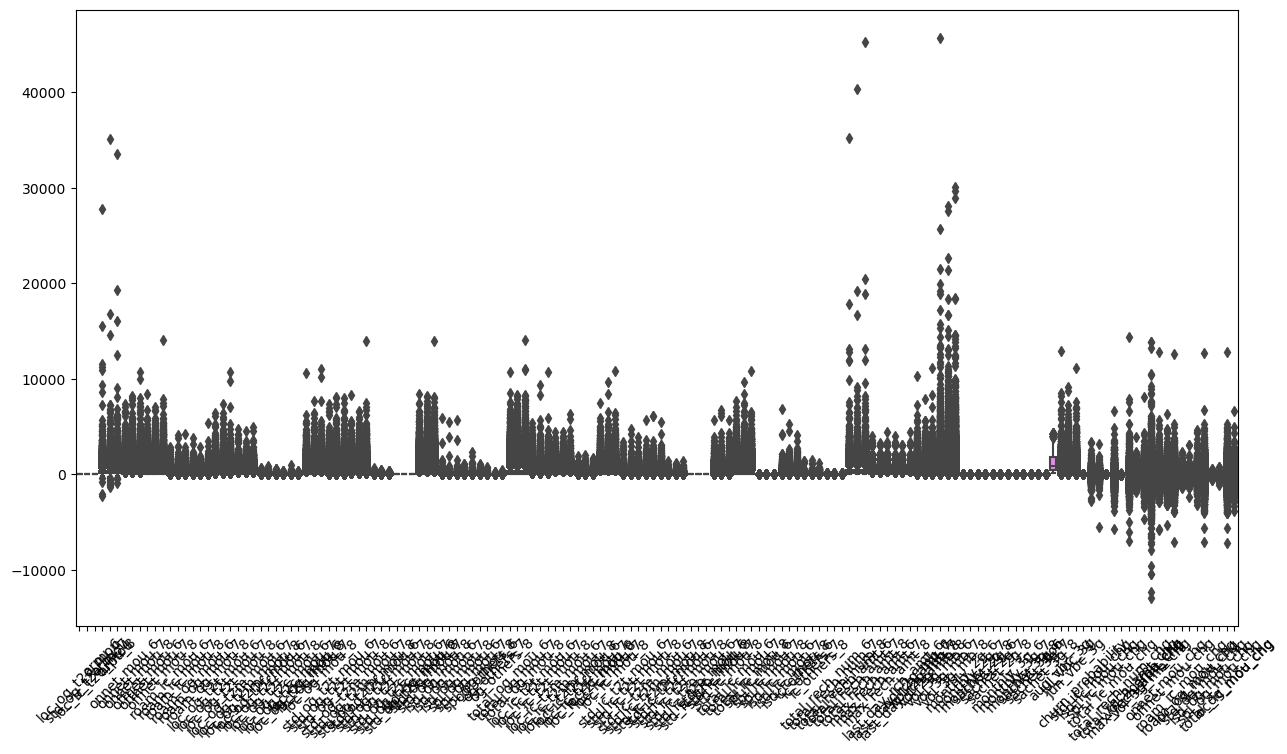

In [456]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = data)

<h2>We see there are outliers and most of the data is on the smaller side</h2>

<h1><b>Bivariate Explorative Data Analysis</h1>

In [ ]:
sns.regplot(x = "churn_probability", 
            y = "arpu_6", 
            data = data)


In [ ]:
sns.regplot(x = "churn_probability", 
            y = "sachet_3g_6", 
            data = data)

Cap outliers in all numeric variables with k-sigma technique

In [396]:
data[data.columns] = data[data.columns].apply(pd.to_numeric)

In [397]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [398]:
data[data.columns] = data[data.columns].apply(cap_outliers, axis=0)

<h1><b>Feature scaling</b></h1>

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [399]:
# divide data into train and test
X = data.drop("churn_probability", axis = 1)
y = data.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4, stratify = y)

In [400]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train)

<Axes: >

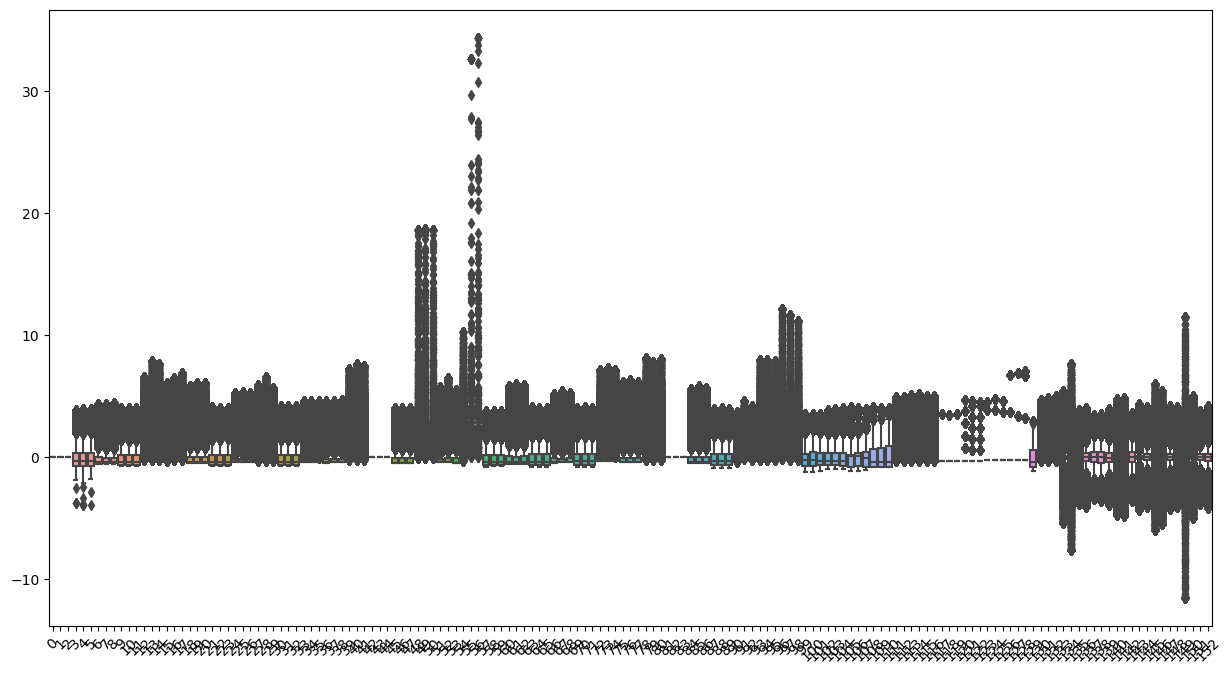

In [401]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2))

<Axes: xlabel='churn_probability', ylabel='Count'>

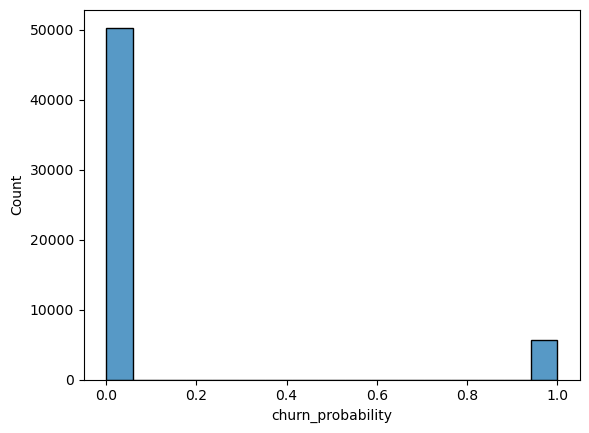

In [402]:
#Distribution for the churn probability
sns.histplot(y_train)

<h1><b1>Feature engineering and selection </b></h1>

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [403]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [404]:
feature_importances = pd.DataFrame({'col':X_train.columns, 'importance':rf.feature_importances_})

<BarContainer object of 153 artists>

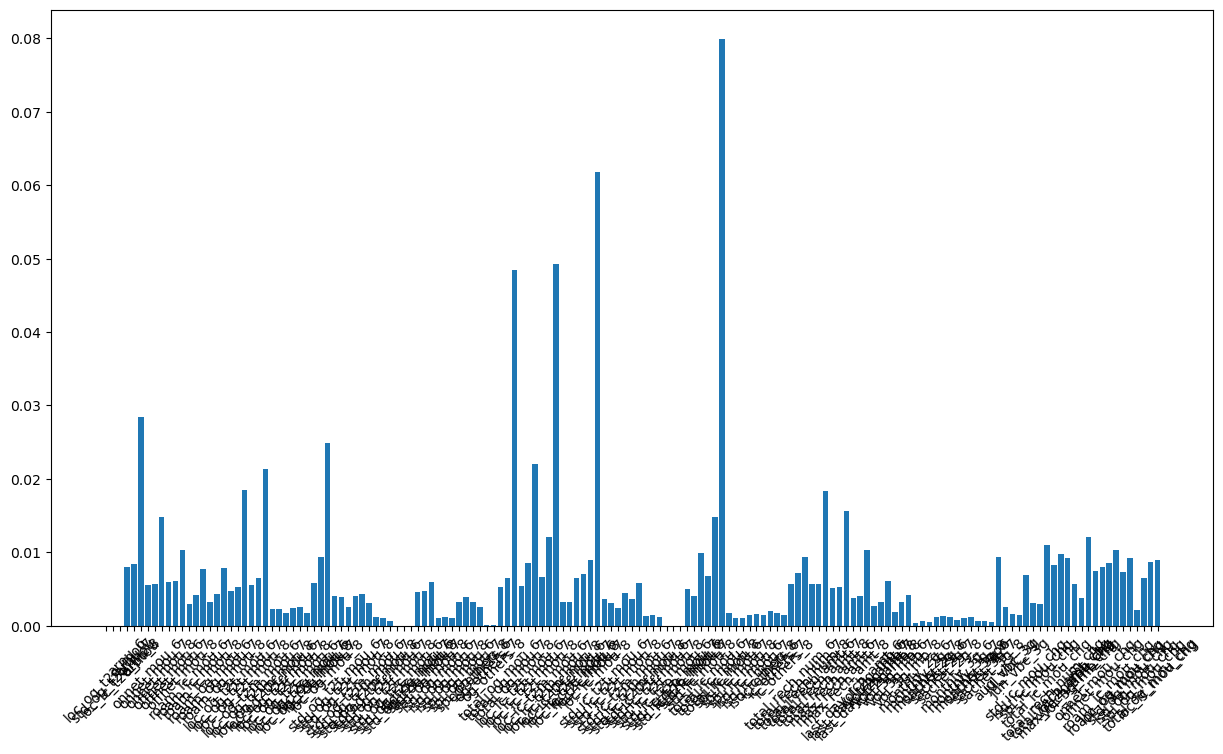

In [405]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<h3>Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. Note: you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.</h3>

<Axes: >

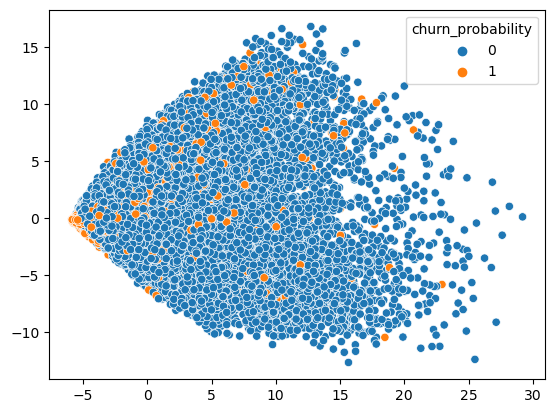

In [406]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

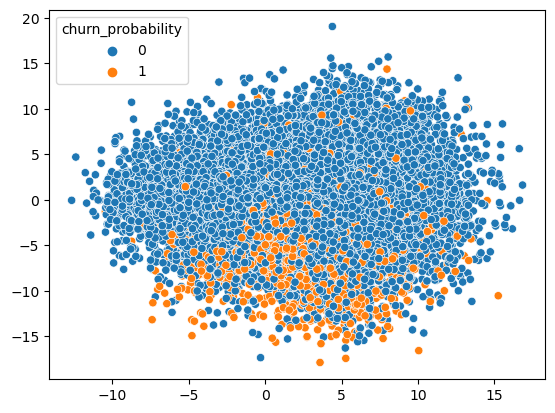

In [407]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

<Axes: >

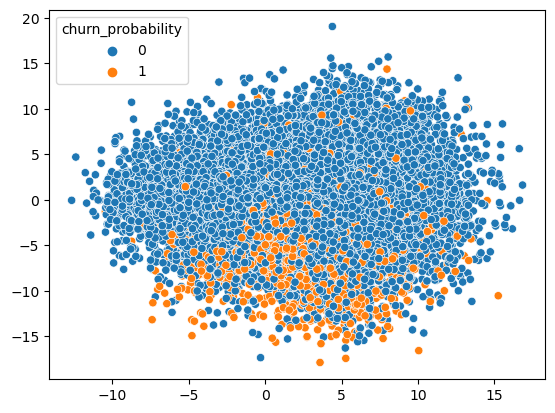

In [408]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [409]:
len(X_train.columns)

153

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 153 artists>

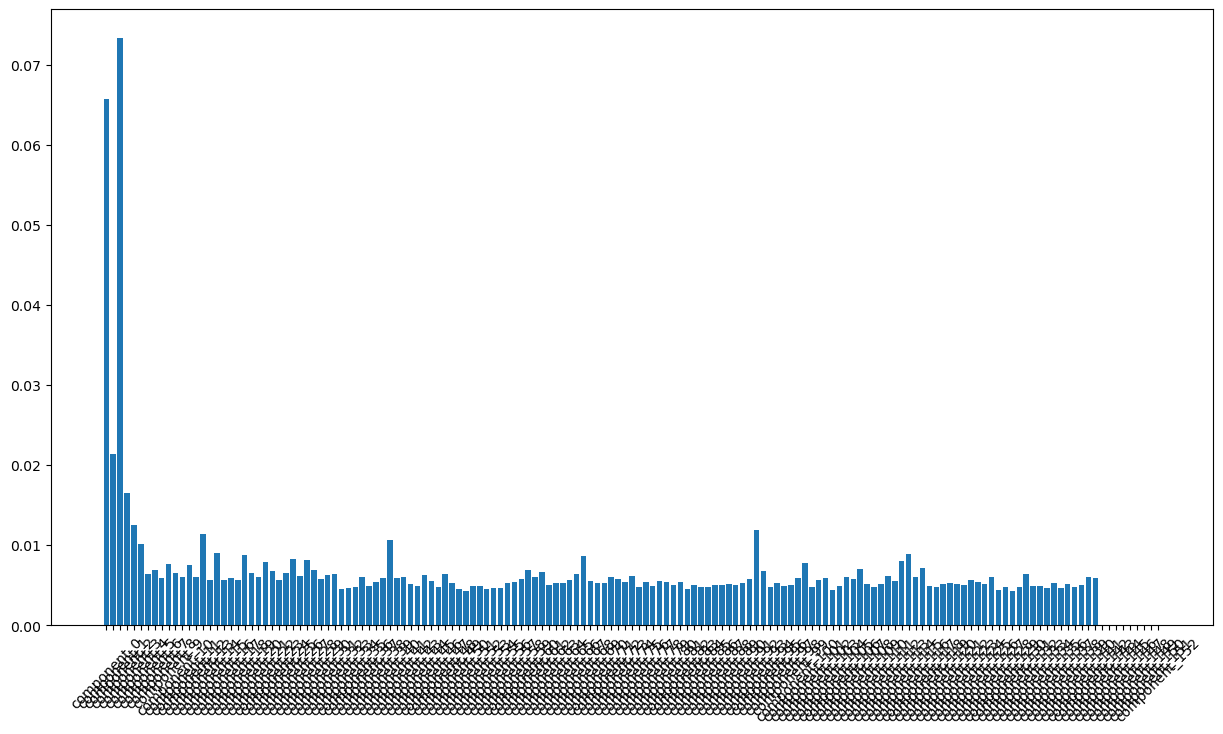

In [410]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(153)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<h1><b>Model building</b></h1>

Let's build a quick model with logistic regression and the first 13 PCA components.

In [411]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag',class_weight='balanced')
lr.fit(pca_components[:,:13], y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='sag',
                   tol=0.001)

In [412]:
lr.score(pca_components[:,:13], y_train)

0.7829425525455812

The model has 78.3% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -

Imputation
Scaling
PCA
Classification model
You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [413]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001,class_weight='balanced')

In [414]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [415]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    tol=0.001))])

In [416]:
train_score = pipe.score(X_train, y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.779531777353167


In [417]:
test_score = pipe.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.7809285714285714


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [418]:
confusion_matrix(y_train, pipe.predict(X_train))

array([[38858, 11435],
       [  911,  4795]])

In [419]:
confusion_matrix(y_test, pipe.predict(X_test))

array([[9743, 2831],
       [ 236, 1190]])

In [420]:
precision_score(y_test, pipe.predict(X_test))

0.29594628201939815

In [421]:
recall_score(y_test, pipe.predict(X_test))

0.8345021037868162

<h1><b> 7. Creating submission file </b></h1>

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [422]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [423]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [424]:
unseen['std_ic_mou_chg'] = unseen.std_ic_mou_8 - ((unseen.std_ic_mou_6 + unseen.std_ic_mou_7)/2)

unseen['isd_ic_mou_chg'] = unseen.isd_ic_mou_8 - ((unseen.isd_ic_mou_6 + unseen.isd_ic_mou_7)/2)

unseen['spl_ic_mou_chg'] = unseen.spl_ic_mou_8 - ((unseen.spl_ic_mou_6 + unseen.spl_ic_mou_7)/2)

unseen['total_ic_mou_chg'] = unseen.total_ic_mou_8 - ((unseen.total_ic_mou_6 + unseen.total_ic_mou_7)/2)

unseen['total_rech_num_chg'] = unseen.total_rech_num_8 - ((unseen.total_rech_num_6 + unseen.total_rech_num_7)/2)

unseen['total_rech_amt_chg'] = unseen.total_rech_amt_8 - ((unseen.total_rech_amt_6 + unseen.total_rech_amt_7)/2)

unseen['max_rech_amt_chg'] = unseen.max_rech_amt_8 - ((unseen.max_rech_amt_6 + unseen.max_rech_amt_7)/2)

unseen['vol_2g_mb_chg'] = unseen.vol_2g_mb_8 - ((unseen.vol_2g_mb_6 + unseen.vol_2g_mb_7)/2)

unseen['vol_3g_mb_chg'] = unseen.vol_3g_mb_8 - ((unseen.vol_3g_mb_6 + unseen.vol_3g_mb_7)/2)

unseen['arpu_chg'] = unseen.arpu_8 - ((unseen.arpu_6 + unseen.arpu_7)/2)

unseen['onnet_mou_chg'] = unseen.onnet_mou_8 - ((unseen.onnet_mou_6 + unseen.onnet_mou_7)/2)

unseen['offnet_mou_chg'] = unseen.offnet_mou_8 - ((unseen.offnet_mou_6 + unseen.offnet_mou_7)/2)

unseen['roam_ic_mou_chg'] = unseen.roam_ic_mou_8 - ((unseen.roam_ic_mou_6 + unseen.roam_ic_mou_7)/2)

unseen['roam_og_mou_chg'] = unseen.roam_og_mou_8 - ((unseen.roam_og_mou_6 + unseen.roam_og_mou_7)/2)

unseen['loc_og_mou_chg'] = unseen.loc_og_mou_8 - ((unseen.loc_og_mou_6 + unseen.loc_og_mou_7)/2)

unseen['std_og_mou_chg'] = unseen.std_og_mou_8 - ((unseen.std_og_mou_6 + unseen.std_og_mou_7)/2)

unseen['isd_og_mou_chg'] = unseen.isd_og_mou_8 - ((unseen.isd_og_mou_6 + unseen.isd_og_mou_7)/2)

unseen['spl_og_mou_chg'] = unseen.spl_og_mou_8 - ((unseen.spl_og_mou_6 + unseen.spl_og_mou_7)/2)

unseen['total_og_mou_chg'] = unseen.total_og_mou_8 - ((unseen.total_og_mou_6 + unseen.total_og_mou_7)/2)

unseen['loc_ic_mou_chg'] = unseen.loc_ic_mou_8 - ((unseen.loc_ic_mou_6 + unseen.loc_ic_mou_7)/2)

In [425]:
unseen_filtered = unseen[X_train.columns]

In [426]:
unseen_filtered.isnull().sum()*100/unseen_filtered.shape[0]

loc_og_t2o_mou        1.053333
std_og_t2o_mou        1.053333
loc_ic_t2o_mou        1.053333
arpu_6                0.000000
arpu_7                0.000000
arpu_8                0.000000
onnet_mou_6           3.896667
onnet_mou_7           3.906667
onnet_mou_8           5.583333
offnet_mou_6          3.896667
offnet_mou_7          3.906667
offnet_mou_8          5.583333
roam_ic_mou_6         3.896667
roam_ic_mou_7         3.906667
roam_ic_mou_8         5.583333
roam_og_mou_6         3.896667
roam_og_mou_7         3.906667
roam_og_mou_8         5.583333
loc_og_t2t_mou_6      3.896667
loc_og_t2t_mou_7      3.906667
loc_og_t2t_mou_8      5.583333
loc_og_t2m_mou_6      3.896667
loc_og_t2m_mou_7      3.906667
loc_og_t2m_mou_8      5.583333
loc_og_t2f_mou_6      3.896667
loc_og_t2f_mou_7      3.906667
loc_og_t2f_mou_8      5.583333
loc_og_t2c_mou_6      3.896667
loc_og_t2c_mou_7      3.906667
loc_og_t2c_mou_8      5.583333
loc_og_mou_6          3.896667
loc_og_mou_7          3.906667
loc_og_m

Replace null values with zeros

In [427]:
unseen_filtered = unseen_filtered.apply(lambda x: x.fillna(0))

In [428]:
unseen['churn_probability'] = pipe.predict(unseen_filtered)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,1
1,70000,0
2,70001,1
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [429]:
output.to_csv('submission_pca_lr_Sep8.csv',index=False)

<h1><b>Modelling</b></h1>

In [224]:
# divide data into train and test
X = data.drop("churn_probability", axis = 1)
y = data.churn_probability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4, stratify = y)

<h1><b>Let us apply PCA </b></h1>

In [226]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [227]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [228]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       13.85
1       21.40
2       27.67
3       32.44
4       36.46
5       39.67
6       42.22
7       44.61
8       46.77
9       48.86
10      50.90
11      52.75
12      54.58
13      56.21
14      57.80
15      59.31
16      60.78
17      62.22
18      63.56
19      64.85
20      66.11
21      67.31
22      68.46
23      69.58
24      70.64
25      71.66
26      72.68
27      73.68
28      74.68
29      75.63
30      76.52
31      77.38
32      78.21
33      79.02
34      79.82
35      80.60
36      81.37
37      82.08
38      82.74
39      83.39
40      84.00
41      84.58
42      85.13
43      85.67
44      86.19
45      86.69
46      87.16
47      87.61
48      88.05
49      88.46
50      88.85
51      89.24
52      89.63
53      90.00
54      90.37
55      90.73
56      91.09
57      91.43
58      91.76
59      92.09
60      92.41
61      92.71
62      93.00
63      93.29
64      93.57
65      93.84
66      94.10
67      94.34
68      94.58
69      94.81
70      95.04
71    

~53 components explain 90% variance
~70 components explain 95% variance

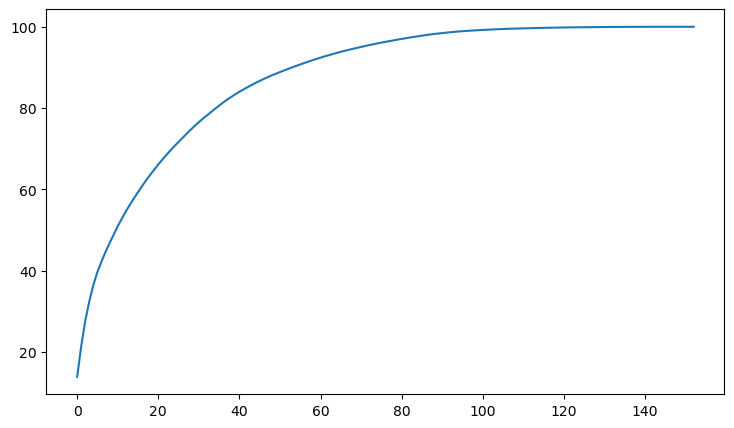

In [229]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

<h1><b>PCA and Logistic Regression</b></h1>

In [232]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.7973535241700744

<h1><b>Evaluate with test data</b></h1>

In [237]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[9979 2595]
 [ 217 1209]]
Sensitivity: 	0.85
Specificity: 	0.79
AUC:    	 0.89


<h1><b>Hyperparameter tuning</b></h1>

In [241]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [242]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [243]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8970537851248892
Best hyperparameters:  {'logistic__C': 0.5, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [244]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[10046  2528]
 [  213  1213]]
Sensitivity: 	0.85
Specificity: 	0.8
AUC:    	 0.9


In [ ]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

<h1><b>Choosing best features</b></h1>

In [246]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

12


In [247]:
# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   25.8s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=12,
                       oob_score=True, random_state=4, verbose=1)

In [248]:
# OOB score
rf_model.oob_score_

0.9404096501723245

In [249]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[12355   219]
 [  594   832]]
Sensitivity: 	0.58
Specificity: 	0.98
ROC:    	 0.94


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [252]:
features = X_train.columns
# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Importance Sum=", feature_importance.importance_percentage.sum())
feature_importance

Importance Sum= 99.99999999999997


,variables,importance_percentage
0,loc_ic_mou_8,6.286897
1,total_ic_mou_8,5.856245
2,loc_og_mou_8,4.840351
3,loc_ic_t2m_mou_8,4.543225
4,loc_og_t2m_mou_8,3.675603
5,loc_ic_t2t_mou_8,3.518400
6,total_og_mou_8,3.323529
7,total_rech_amt_8,3.213615
8,loc_og_t2t_mou_8,2.585856
9,last_day_rch_amt_8,2.182990


<h1><b>Extracting top 25 features</b></h1>

In [254]:
top_features = feature_importance.variables[0:25]

<Axes: >

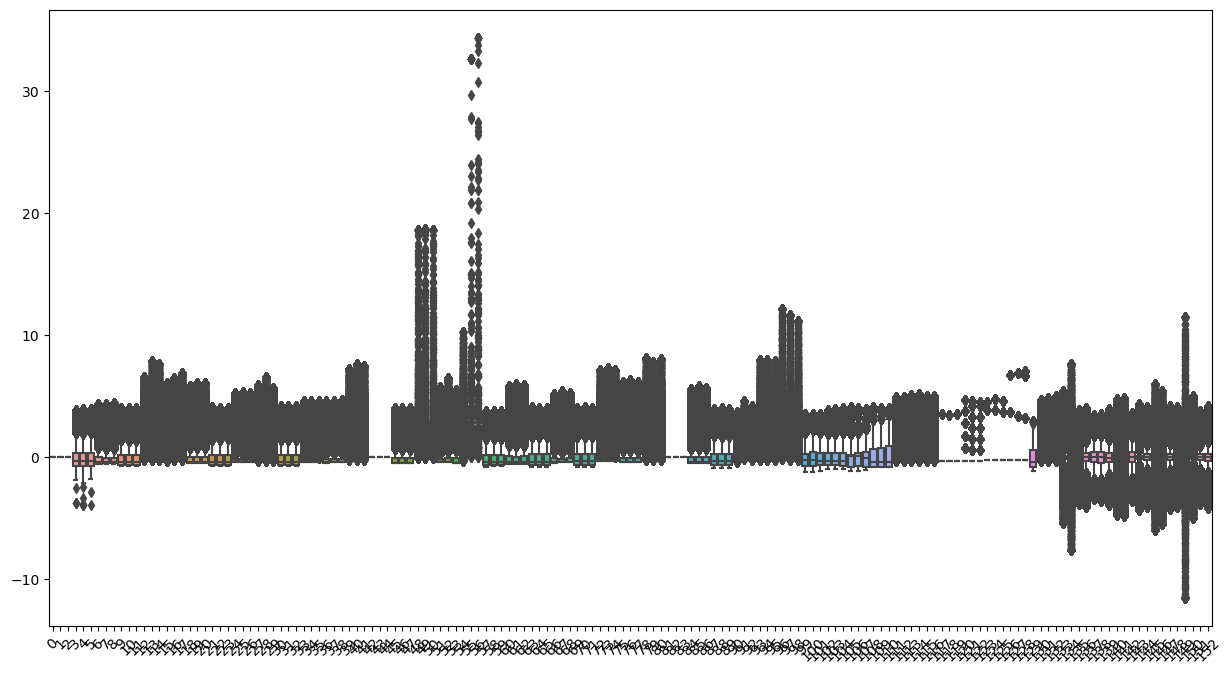

In [188]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

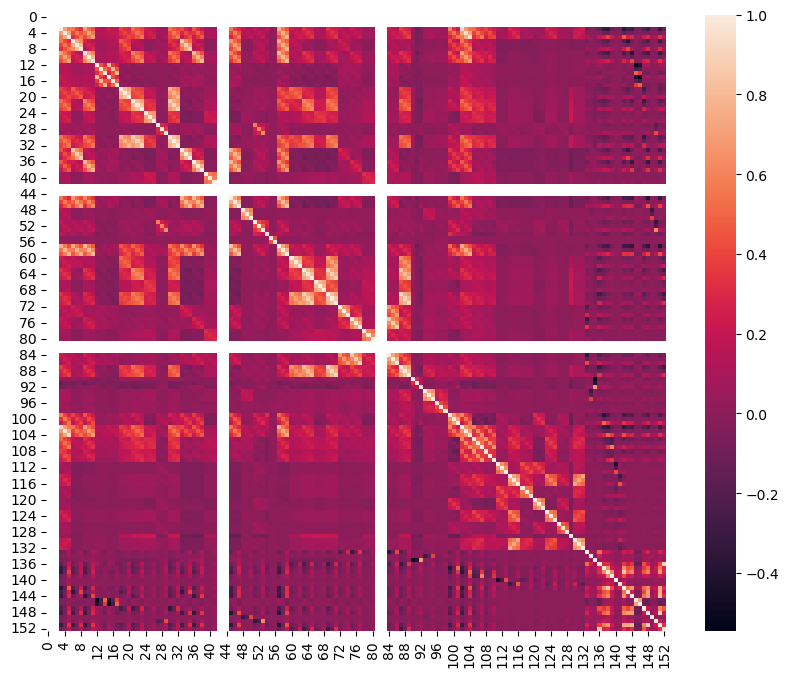

In [190]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

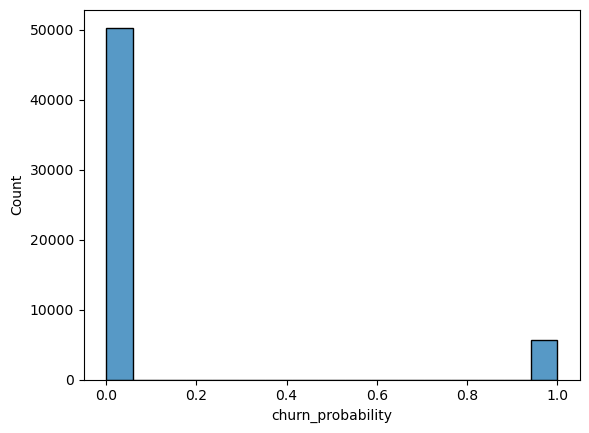

In [191]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [61]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [62]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 16 artists>

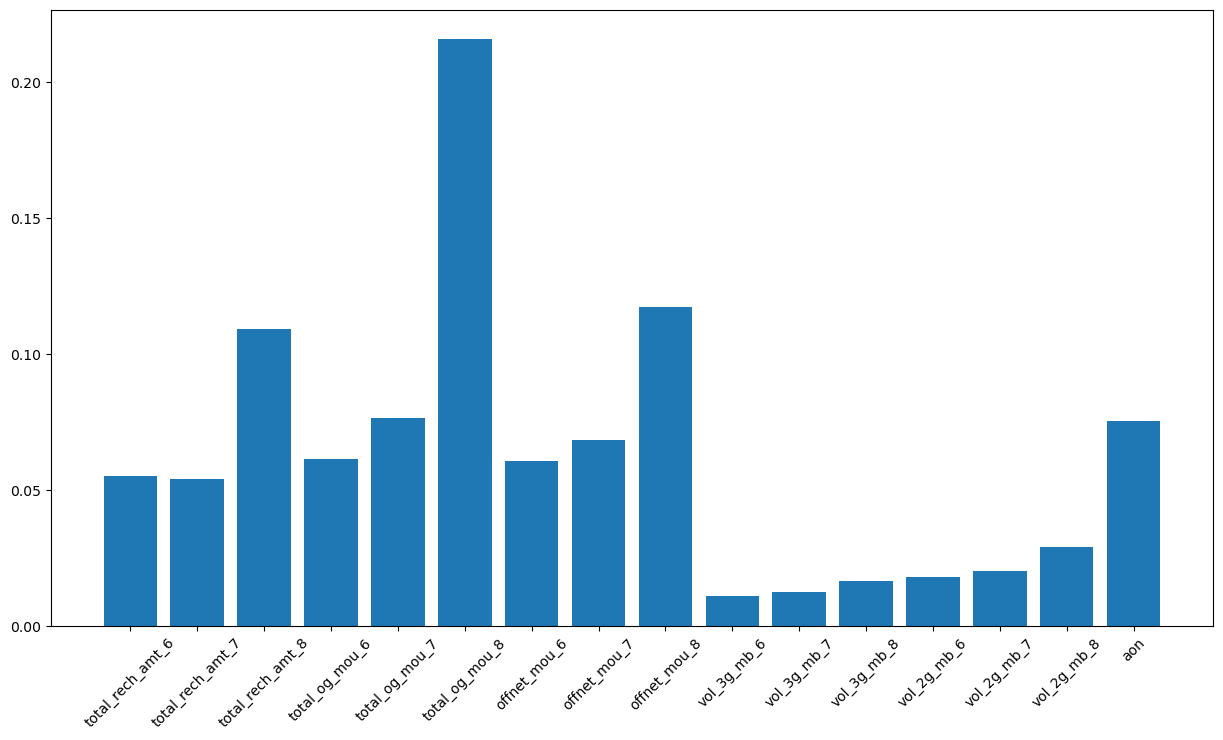

In [63]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<Axes: >

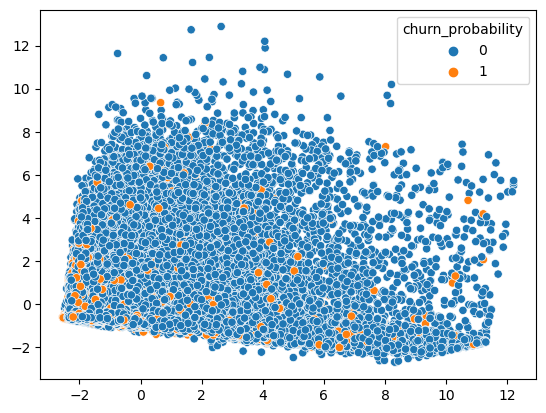

In [64]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

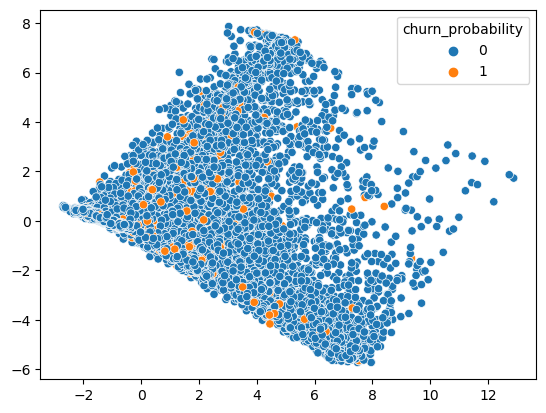

In [65]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

<BarContainer object of 16 artists>

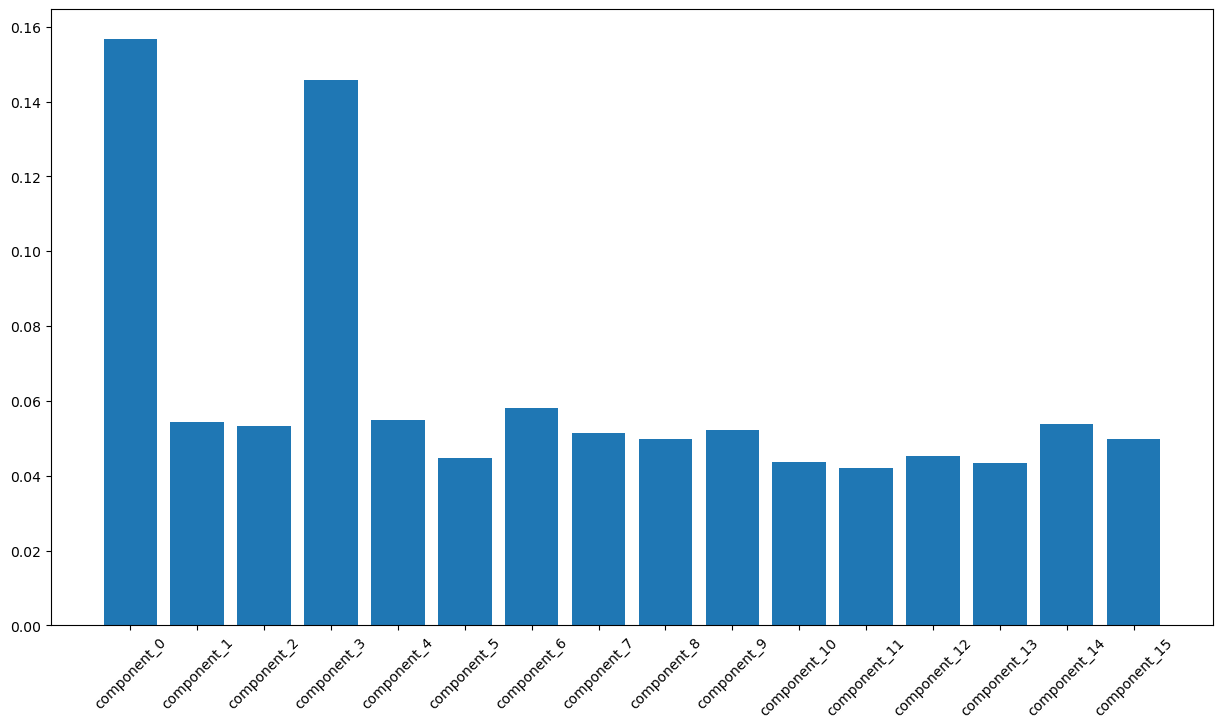

In [66]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [69]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [70]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [71]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [72]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9000339291773067


In [73]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9009285714285714


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [74]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50006,   269],
       [ 5329,   395]])

In [75]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12525,    67],
       [ 1320,    88]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [76]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.567741935483871

In [77]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.0625

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [80]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [81]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [82]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 16)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [83]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [84]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.